# Testing regularization of likelihood functions

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Creating the forward model

In [125]:
batch_size=512
# This is the linear operator
A = tf.constant(randn(2,1), dtype=tf.float32)

# Defining probabilistic forward model
prior = tfd.Normal(loc=[0.,0.], scale=[1.,1.])

# Defining the forward model
x = prior.sample(batch_size)
p = tfd.Poisson(log_rate=tf.matmul(x, A))
y = tf.reshape(p.sample(), (-1,))

In [109]:
sx,sy = sess.run([x, y])

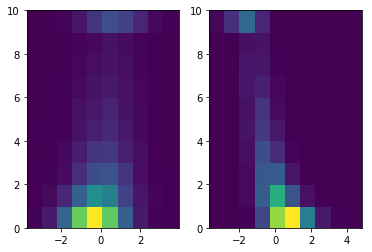

In [110]:
subplot(121)
hist2d(sx[:,0], clip(sy.flatten(),0,10));
subplot(122)
hist2d(sx[:,1], clip(sy.flatten(),0,10));

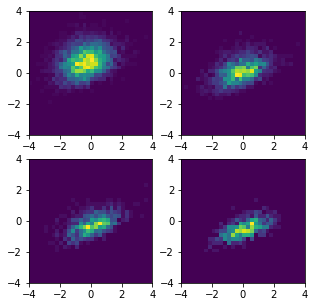

In [111]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
for i in range(4):
    subplot(2,2,i+1)
    m = (sy == i)
    hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True);gca().set_aspect('equal');

In [ ]:
# Now, let's try to train a neural network to model the likelihood function

In [129]:
net = tf.layers.dense(x,32)
net = tf.layers.dense(net,1)
out_prob = tfd.Poisson(log_rate=net)
pred = out_prob.sample()

loss = -tf.reduce_mean(out_prob.log_prob(tf.expand_dims(y, axis=-1)))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [133]:
sess.run(tf.global_variables_initializer())

In [134]:
losses =[]
for i in range(1000):
    l,_= sess.run([loss, train_op])
    losses.append(l)

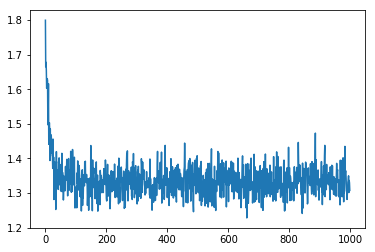

In [135]:
plot(losses)

In [137]:
# Try to predict the outcome
tp, ty = sess.run([pred,y])

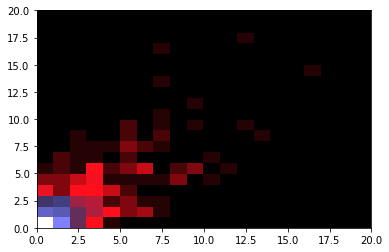

In [147]:
hist2d(tp[:,0],ty,20,range=[[0,20],[0,20]],cmap='gist_stern');

Ok, fair enough

In [148]:
# Now, let's see what happens if we try to maximize p(y | x) with respect to x 

In [152]:
obs_y = 4* ones((512,1))
lp = out_prob.log_prob(obs_y)

Ok, so there is a little bit of code restructuring to do, but the idea here is to see if when we do gradient descent over x, we end up far away from a credible input x value, by that I mean, is $\hat{x}$ within the posterior on x for y=4